In [98]:
import pandas as pd
import yaml
import os

with open("../config.yaml","r") as file_object:
  config=yaml.load(file_object, Loader=yaml.SafeLoader)
assert config

data_dir = os.path.join(os.path.pardir, config['data_dir'])
players_csv = os.path.join(data_dir, 'players.csv')
teams_csv = os.path.join(data_dir, 'teams.csv')
games_csv = os.path.join(data_dir, 'games.csv')

players_df = pd.read_csv(players_csv)
teams_df = pd.read_csv(teams_csv)
games_df = pd.read_csv(games_csv)

games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55130 entries, 0 to 55129
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          55130 non-null  int64  
 1   TEAM_ID            55130 non-null  int64  
 2   TEAM_ABBREVIATION  55130 non-null  object 
 3   TEAM_NAME          55130 non-null  object 
 4   GAME_ID            55130 non-null  int64  
 5   GAME_DATE          55130 non-null  object 
 6   MATCHUP            55130 non-null  object 
 7   WL                 55128 non-null  object 
 8   MIN                55130 non-null  int64  
 9   FGM                55130 non-null  int64  
 10  FGA                55130 non-null  int64  
 11  FG_PCT             55128 non-null  float64
 12  FG3M               55130 non-null  int64  
 13  FG3A               55130 non-null  int64  
 14  FG3_PCT            55128 non-null  float64
 15  FTM                55130 non-null  int64  
 16  FTA                551

In [100]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import numpy as np

# games_df['time_idx']  = games_df.groupby('SEASON_ID')['SEASON_ID'].cumcount()

# games_df['TEAM_ID'] = games_df['TEAM_ID'].astype(str).astype('category')

games_df['GAME_DATE'] = pd.to_datetime(games_df['GAME_DATE'])
games_df['WL'] = games_df['WL'].astype('category')
games_df['TEAM_ID'] = games_df['TEAM_ID'].astype(str).astype('category')

games_df = games_df.sort_values(['TEAM_ID', 'SEASON_ID', 'GAME_DATE'])
games_df = games_df.drop(columns=['TEAM_ABBREVIATION', 'TEAM_NAME',\
                         'MATCHUP', 'VIDEO_AVAILABLE'], errors='ignore')
games_df['time_idx']  = games_df.groupby(['TEAM_ID', 'SEASON_ID']).cumcount()

games_df['day_of_week'] = games_df['GAME_DATE'].dt.day_of_week
games_df = games_df.dropna()

games_df.info()
# TODO: add additional features
# TODO: entity embedding for: TEAM_ID

training_cutoff = 60

# alternative is to group by season and encode team_id

max_prediction_length = 1
max_encoder_length = 30

training = TimeSeriesDataSet(
    games_df[lambda x: x.time_idx < training_cutoff],
    time_idx='time_idx',
    target='WL',
    group_ids=['SEASON_ID', 'TEAM_ID'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['TEAM_ID'],
    time_varying_known_categoricals=['TEAM_ID'],
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_reals=[
        "PTS"
    ],
    # target_normalizer=GroupNormalizer(
    #     groups=["SEASON_ID", "TEAM_ID"], transformation="softplus"
    # ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

<class 'pandas.core.frame.DataFrame'>
Index: 55128 entries, 12 to 55103
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   SEASON_ID    55128 non-null  int64         
 1   TEAM_ID      55128 non-null  category      
 2   GAME_ID      55128 non-null  int64         
 3   GAME_DATE    55128 non-null  datetime64[ns]
 4   WL           55128 non-null  category      
 5   MIN          55128 non-null  int64         
 6   FGM          55128 non-null  int64         
 7   FGA          55128 non-null  int64         
 8   FG_PCT       55128 non-null  float64       
 9   FG3M         55128 non-null  int64         
 10  FG3A         55128 non-null  int64         
 11  FG3_PCT      55128 non-null  float64       
 12  FTM          55128 non-null  int64         
 13  FTA          55128 non-null  int64         
 14  FT_PCT       55128 non-null  float64       
 15  OREB         55128 non-null  int64         
 16  DREB    

/tmp/ipykernel_8064/800207880.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  games_df['time_idx']  = games_df.groupby(['TEAM_ID', 'SEASON_ID']).cumcount()
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:572: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)


In [70]:
print(games_df.groupby(['SEASON_ID', 'TEAM_ID'])['SEASON_ID'].count().sort_values(ascending=True))
# some 0 games, min is 64, max is 82
# 

SEASON_ID  TEAM_ID   
22001      1610612740     0
22003      1610612766     0
22002      1610612766     0
22000      1610612740     0
22019      1610612750    64
                         ..
22007      1610612751    82
           1610612752    82
           1610612753    82
           1610612755    82
22022      1610612766    82
Name: SEASON_ID, Length: 690, dtype: int64


/tmp/ipykernel_8064/1622252504.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(games_df.groupby(['SEASON_ID', 'TEAM_ID'])['SEASON_ID'].count().sort_values(ascending=True))


In [101]:
validation = TimeSeriesDataSet.from_dataset(training, games_df, predict=True, stop_randomization=True)

batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [87]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/tmp/ipykernel_8064/2174382858.py:2: UserWarning: In pytorch-forecasting models, from version 1.2.0, the default optimizer will be 'adam', in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `se

tensor(0.4388, device='cuda:0')

In [88]:
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import lightning.pytorch as pl

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 18.1k


/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
Finding best initial lr: 100%|██████████| 100/100 [00:06<00:00, 16.25it/s]/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:836: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expl

suggested learning rate: 0.09332543007969905


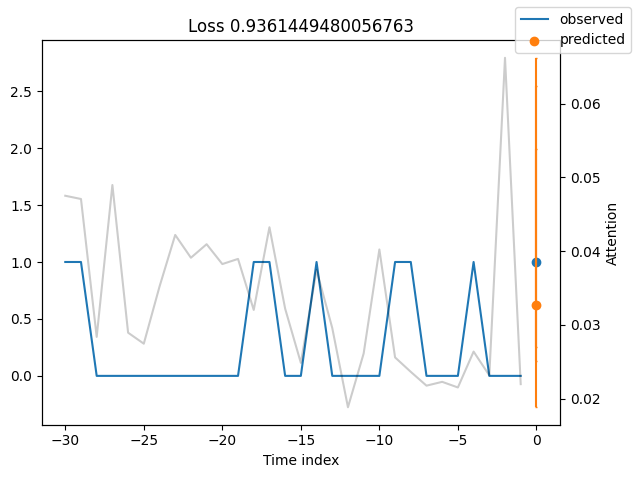

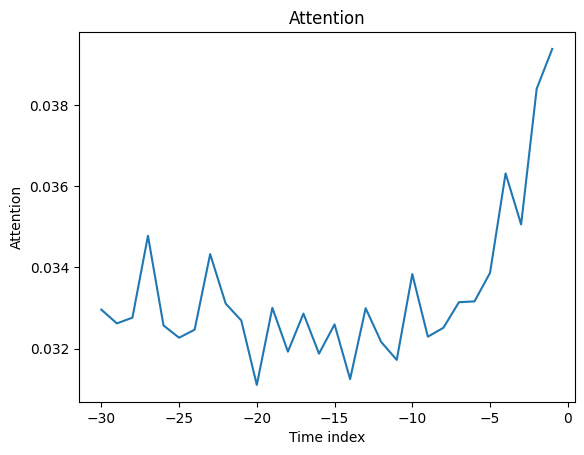

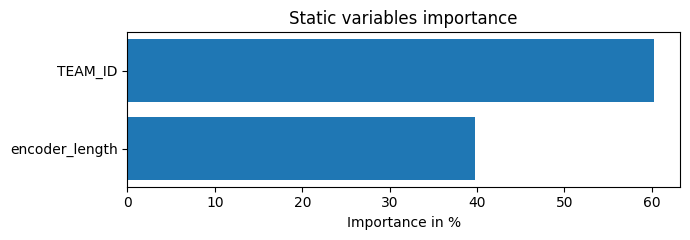

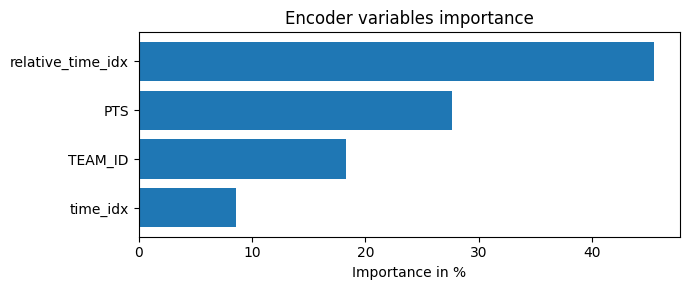

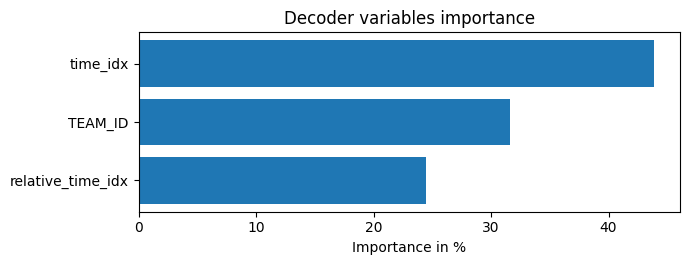

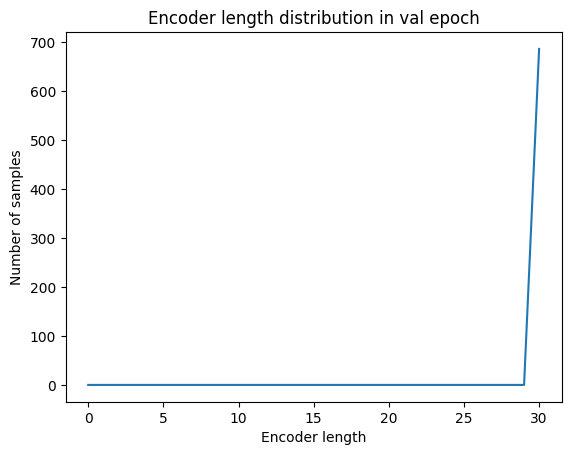

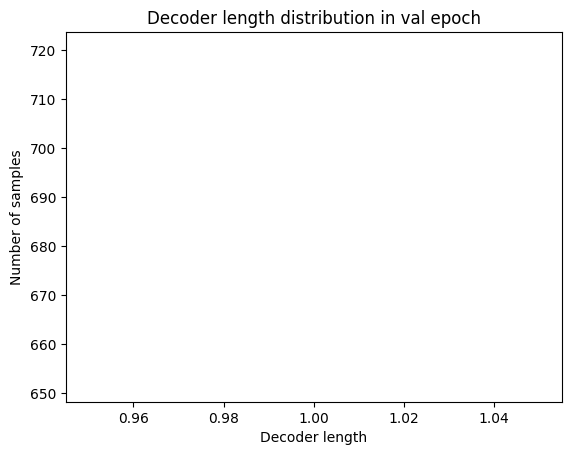

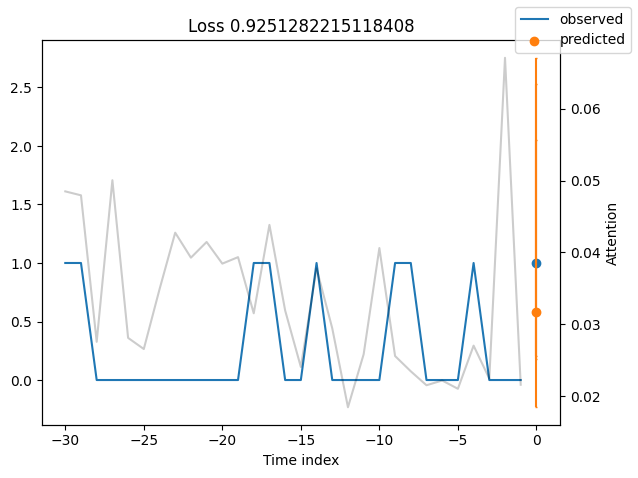

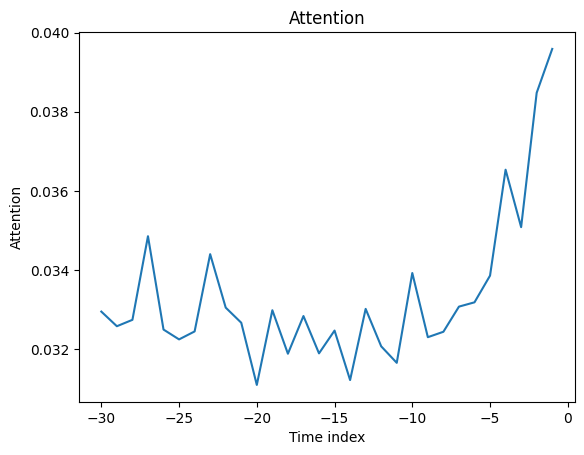

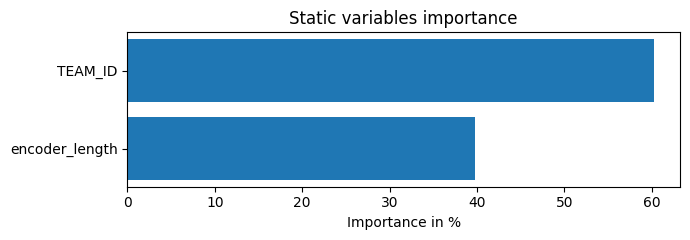

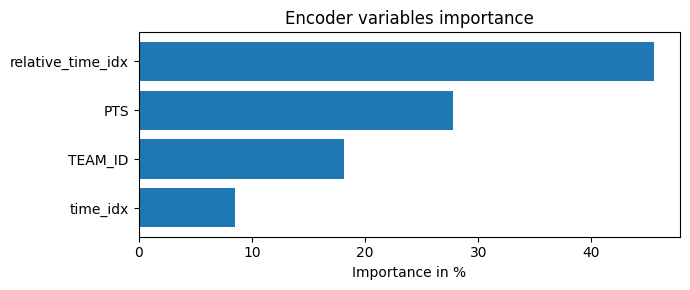

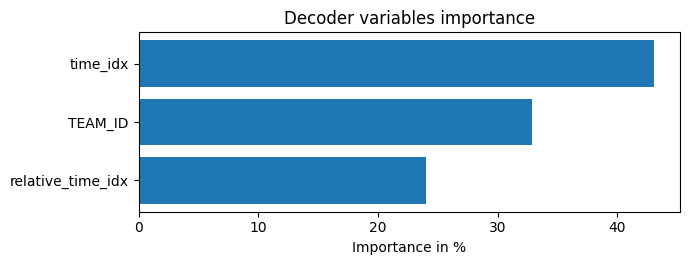

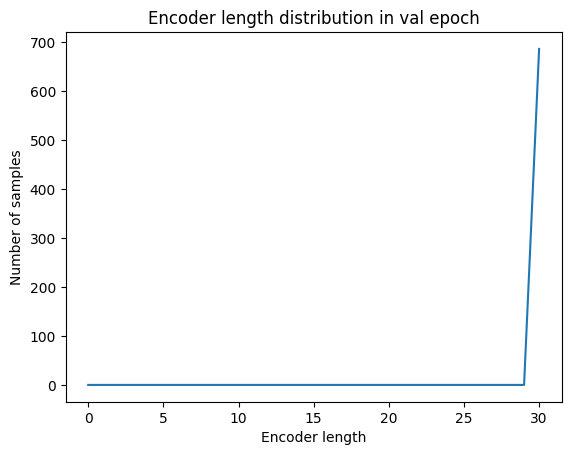

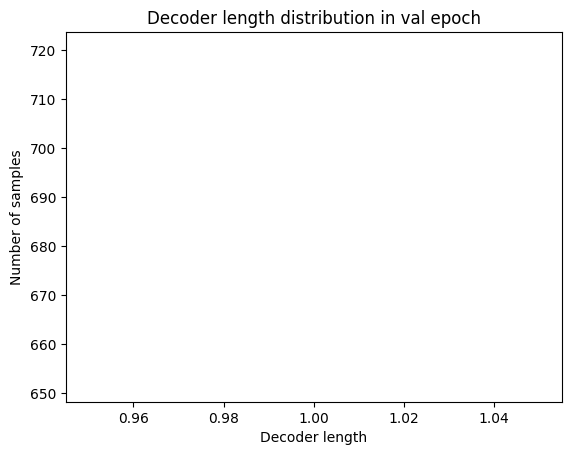

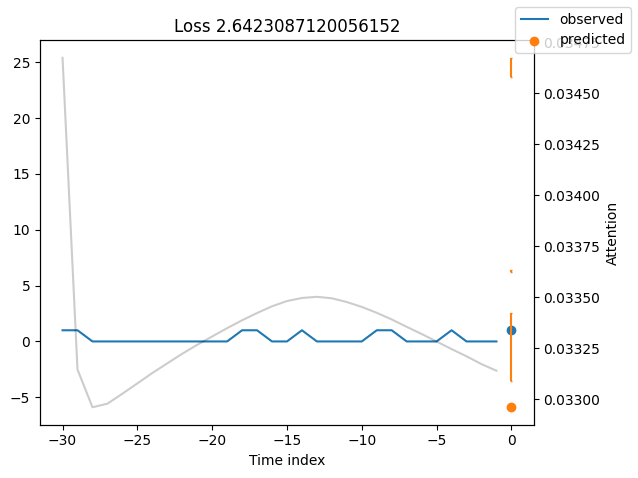

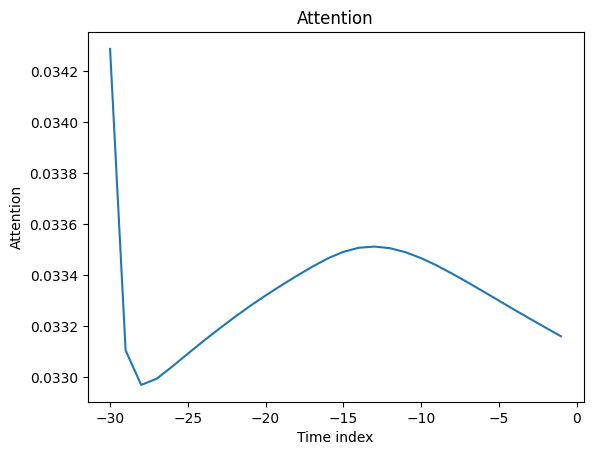

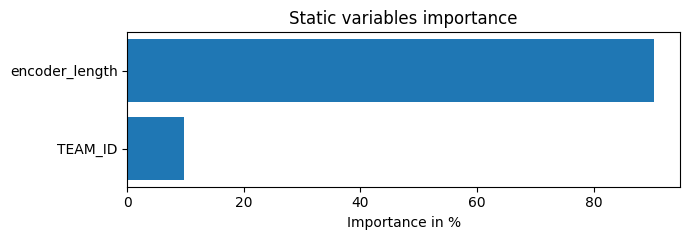

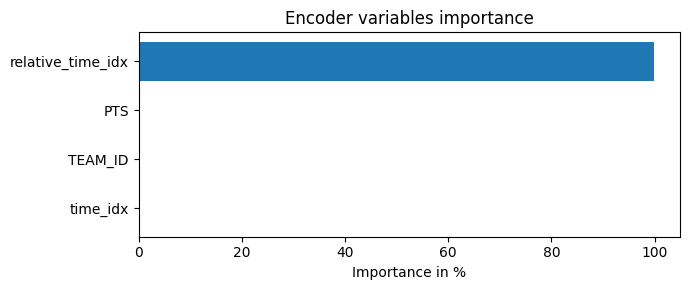

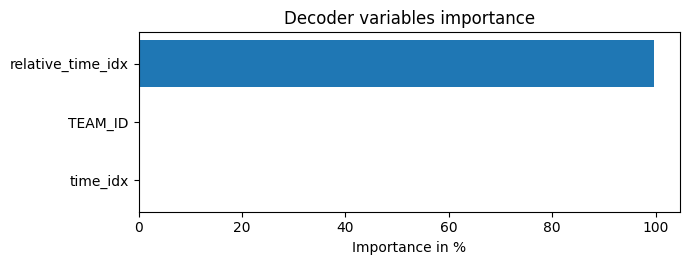

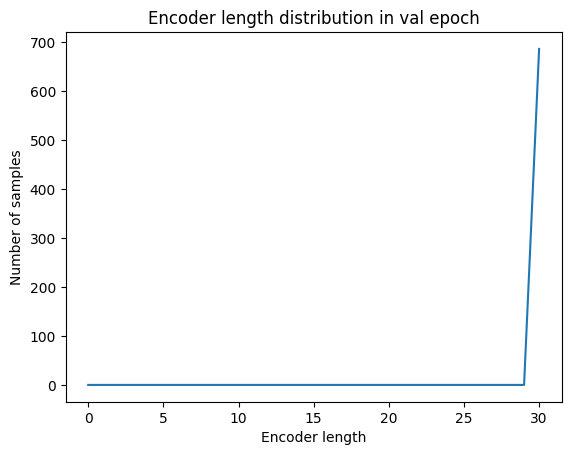

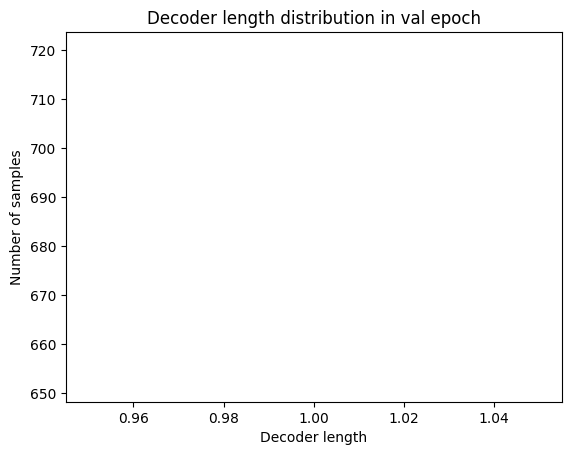

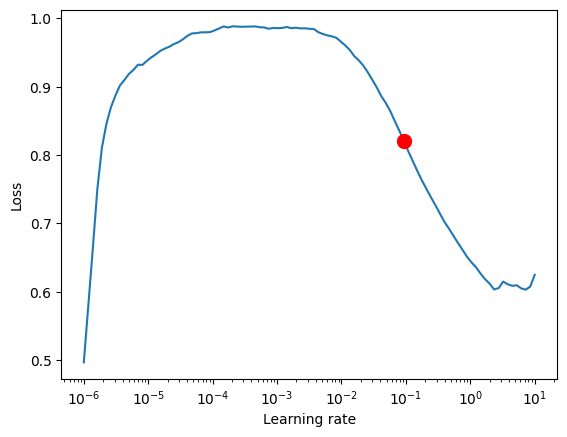

/tmp/ipykernel_8064/4268711780.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [74]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [89]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 330    | train
3  | prescalers                         | ModuleDict                      | 64     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 644    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.9 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 18: 100%|██████████| 50/50 [00:03<00:00, 12.82it/s, v_num=8, train_loss_step=0.171, val_loss=0.183, train_loss_epoch=0.176]


In [90]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [91]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


tensor(0.5127)

In [92]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


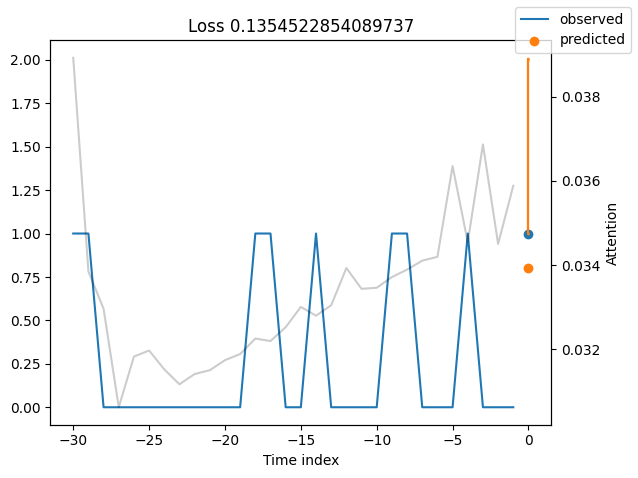

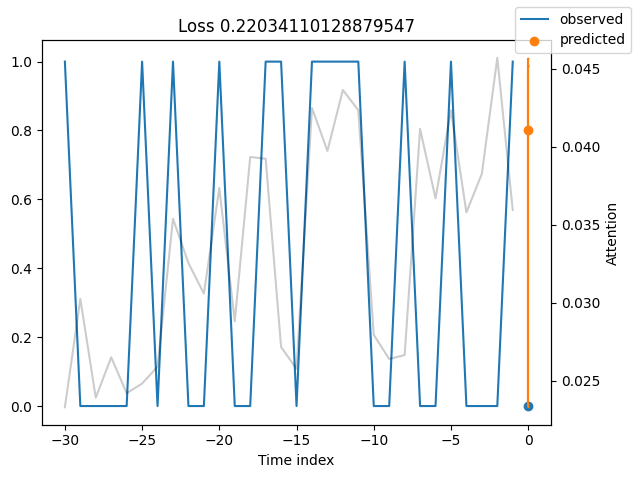

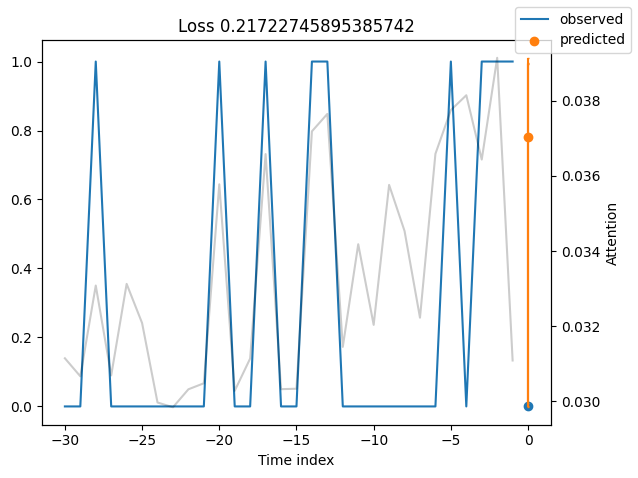

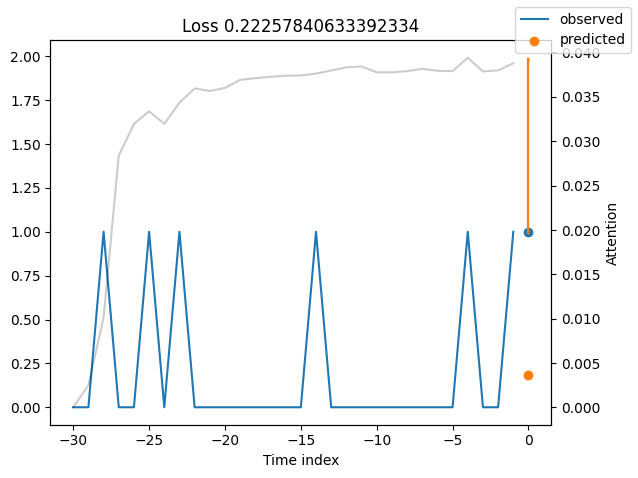

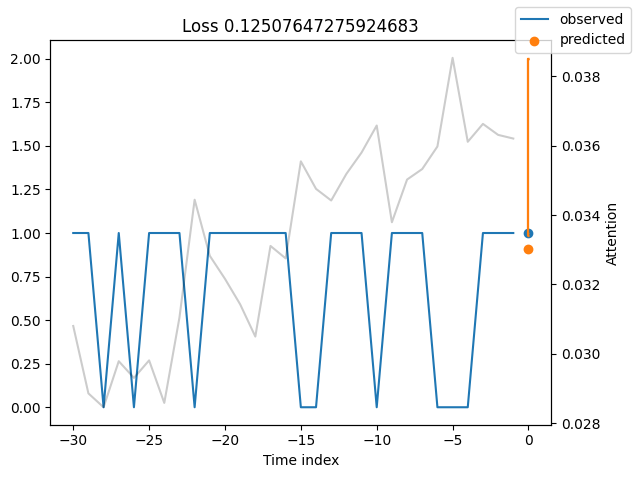

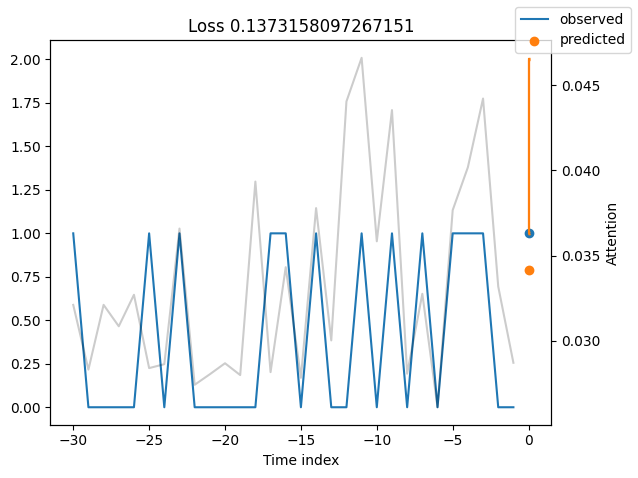

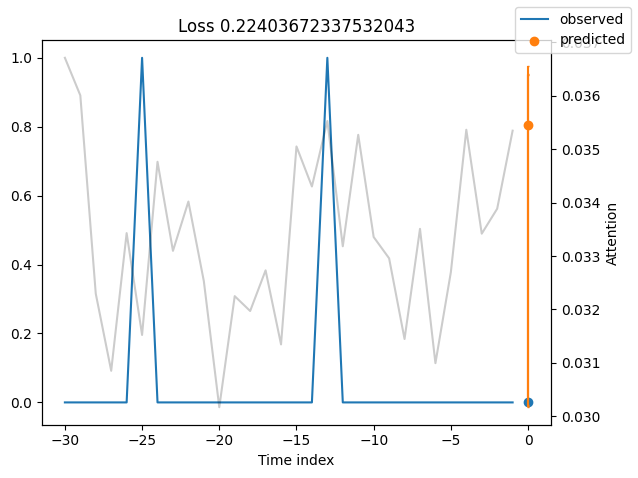

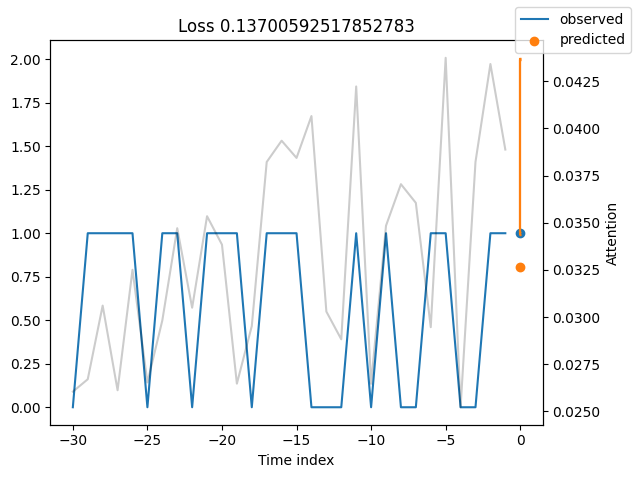

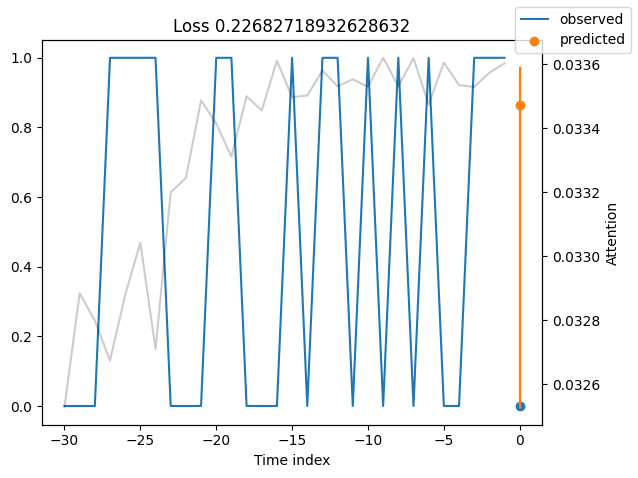

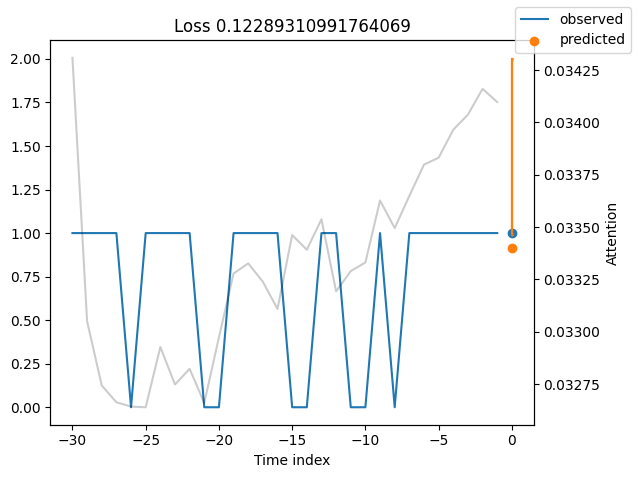

In [93]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [95]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

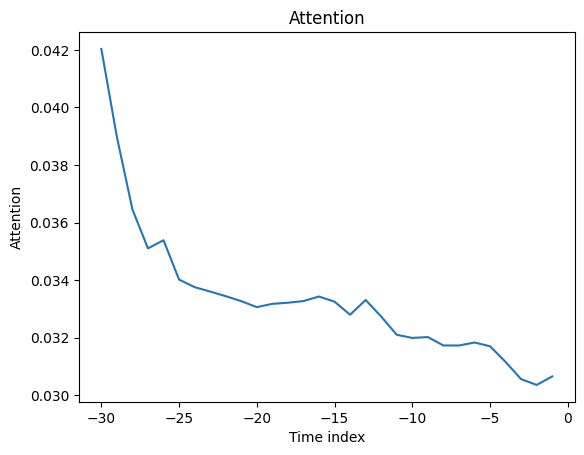

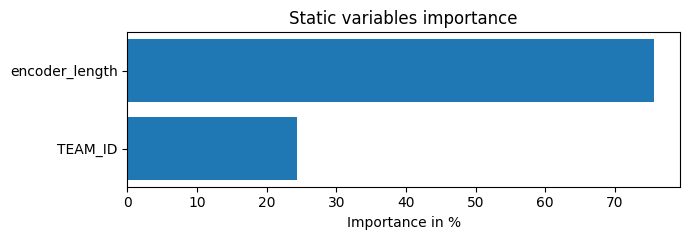

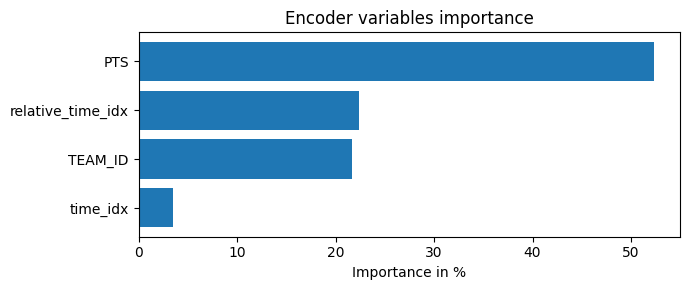

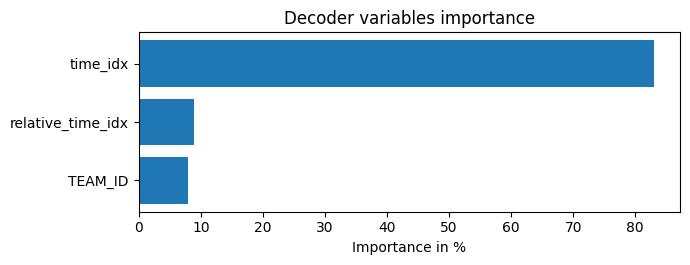

In [51]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)


In [75]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2024-10-07 15:20:53,151] A new study created in memory with name: no-name-a01a1267-a779-4d4c-90e9-90bb0d35fb0b
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:137: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:161: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_

{'gradient_clip_val': 0.1457224568358847, 'hidden_size': 14, 'dropout': 0.1211919558784923, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.06117562484226708}


In [76]:
with open("test_study.pkl", "rb") as fin:
    study_loaded = pickle.load(fin)

In [78]:
study_loaded.best_params

{'gradient_clip_val': 0.1457224568358847,
 'hidden_size': 14,
 'dropout': 0.1211919558784923,
 'hidden_continuous_size': 14,
 'attention_head_size': 4,
 'learning_rate': 0.06117562484226708}

In [82]:
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.14,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft_studied = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.08,
    hidden_size=14,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=14,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [83]:
trainer.fit(
    tft_studied,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory lightning_logs/lightning_logs/version_7/checkpoints exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 330    | train
3  | prescalers                         | ModuleDict                      | 112    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.0 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.1 K  | train
6  | decoder_variable_selection         | VariableSele

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 50/50 [00:04<00:00, 11.16it/s, v_num=7, train_loss_step=0.189, val_loss=0.187, train_loss_epoch=0.361]


In [84]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/lukas/anaconda3/envs/SIS/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: T

tensor(0.4853)